# **ML Assignment 7**
Submitted by Kshitij Mittal

## **PART A: Recurrent Neural Network & Classification:**

The objective is to detect the security breach by predicting suspicious access using an RNN model and the provided Logfile data.

Logfile data includes login information like LogID, Timestamp, Method, Path, Status Code, Source, Remote Address, User Agent etc. The last indicator in each row denotes breach(1) and no breach(0) which is the target variable.

---
### Part 1. Data Processing

In [34]:
import sys
import os
import json
import pandas as pd
import numpy
import optparse

from keras.callbacks import TensorBoard
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout, Embedding
# from keras.layers.Embedding import Embedding
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

from tqdm import tqdm

# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'


In [5]:
import tensorflow as tf
from tensorflow import keras
from keras_preprocessing.sequence import pad_sequences

In [6]:
#pip install pandarallel
import multiprocessing

num_processors = multiprocessing.cpu_count()
print(f'Available CPUs: {num_processors}')

import pandarallel
from pandarallel import pandarallel
pandarallel.initialize(nb_workers=num_processors-1, use_memory_fs=False)

Available CPUs: 8
INFO: Pandarallel will run on 7 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [14]:
dataframe = pd.read_csv("/Users/kshitijmittal/Documents/UChicago Acad/uchicago_codebase/06_MachineLearning/06_RNNs_LSTMs/00_Data/dev-access.csv", engine='python', quotechar='|', header=None)
dataset = dataframe.values

In [15]:
# Shape of the data set
dataset.shape

(26773, 2)

In [16]:
pd.options.display.max_colwidth=1000
dataframe.head()

,0,1
0,"{""timestamp"":1502738402847,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""88.141.113.237"",""referer"":""http://localhost:8002/enter""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""accept-language"":""en-us"",""accept-encoding"":""gzip, deflate"",""connection"":""keep-alive"",""accept"":""*/*"",""referer"":""http://localhost:8002/enter"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""content-type"":""application/json"",""content-length"":""36""},""requestPayload"":{""username"":""Carl2"",""password"":""bo""},""responsePayload"":{""statusCode"":401,""error"":""Unauthorized"",""message"":""Invalid Login""}}",0
1,"{""timestamp"":1502738402849,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""88.141.113.237""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""47""},""requestPayload"":{""username"":""pafzah"",""password"":""worldburn432""},""responsePayload"":{""statusCode"":401,""error"":""Unauthorized"",""message"":""Invalid Login""}}",0
2,"{""timestamp"":1502738402852,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""205.49.83.118""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""44""},""requestPayload"":{""username"":""Panos1"",""password"":""najrijkom""},""responsePayload"":{""statusCode"":401,""error"":""Unauthorized"",""message"":""Invalid Login""}}",0
3,"{""timestamp"":1502738402852,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""205.49.83.118"",""referer"":""http://localhost:8002/enter""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""accept-language"":""en-us"",""accept-encoding"":""gzip, deflate"",""connection"":""keep-alive"",""accept"":""*/*"",""referer"":""http://localhost:8002/enter"",""cache-control"":""no-cache"",""x-requested-with"":""XMLHttpRequest"",""content-type"":""application/json"",""content-length"":""47""},""requestPayload"":{""username"":""vuvpuvehu"",""password"":""password1""},""responsePayload"":{""statusCode"":401,""error"":""Unauthorized"",""message"":""Invalid Login""}}",0
4,"{""timestamp"":1502738402853,""method"":""post"",""query"":{},""path"":""/login"",""statusCode"":401,""source"":{""remoteAddress"":""137.196.95.116""},""route"":""/login"",""headers"":{""host"":""localhost:8002"",""connection"":""keep-alive"",""cache-control"":""no-cache"",""accept"":""*/*"",""accept-encoding"":""gzip, deflate, br"",""accept-language"":""en-US,en;q=0.8,es;q=0.6"",""content-type"":""application/json"",""content-length"":""41""},""requestPayload"":{""username"":""Michele"",""password"":""mokgu""},""responsePayload"":{""statusCode"":401,""error"":""Unauthorized"",""message"":""Invalid Login""}}",0


In [21]:
X = dataset[:,0]
Y = dataset[:,1]
Y

array([0, 0, 0, ..., 1, 1, 1], dtype=object)

In [22]:
for index, item in enumerate(X):
    # Quick hack to space out json elements
    reqJson = json.loads(item, object_pairs_hook=OrderedDict)
    del reqJson['timestamp']
    del reqJson['headers']
    del reqJson['source']
    del reqJson['route']
    del reqJson['responsePayload']
    X[index] = json.dumps(reqJson, separators=(',', ':'))

In [25]:
X

array(['{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"Carl2","password":"bo"}}',
       '{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"pafzah","password":"worldburn432"}}',
       '{"method":"post","query":{},"path":"/login","statusCode":401,"requestPayload":{"username":"Panos1","password":"najrijkom"}}',
       ...,
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<script src=\\"http://attacker/malicious\\u2011script.js\\"></script>"}}',
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<meta http-equiv=\\"refresh\\">"}}',
       '{"method":"post","query":{},"path":"/checkout","statusCode":400,"requestPayload":{"creditCard":"<meta http-equiv=\\"refresh\\">"}}'],
      dtype=object)

In [26]:
# We next will tokenize our data, which just means vectorizing our text. 
# Given the data we will tokenize every character (thus char_level = True)

tokenizer = Tokenizer(filters='\t\n', char_level=True)
tokenizer.fit_on_texts(X)

# we will need this later
num_words = len(tokenizer.word_index)+1
X = tokenizer.texts_to_sequences(X)


In [43]:
# Padding our data
max_log_length = 1024
X_processed = pad_sequences(X, maxlen=max_log_length)

In [49]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test=train_test_split(X_processed,Y,train_size=0.75, test_size=0.25,random_state=1234)

In [111]:
X_train

array([[ 0,  0,  0, ..., 12, 12, 19],
       [ 0,  0,  0, ..., 12, 12, 19],
       [ 0,  0,  0, ..., 12, 12, 19],
       ...,
       [ 0,  0,  0, ...,  1, 19, 19],
       [ 0,  0,  0, ...,  1, 19, 19],
       [ 0,  0,  0, ..., 12, 12, 19]], dtype=int32)

----
### Part 2. Model 1 - Baseline RNN

In [66]:
from keras import layers
base_rnn=keras.Sequential(
    [layers.Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length), ## Only the first layer needs an input dimension
     # We have 63 total words (num_words). We are converting them into dense vectors of size 32. Input length is constant, padded at 1024
     layers.SimpleRNN(units=32, activation='relu'),
     # Output of SimpleRNN is batch size, number of units; so in our case 128 rows, 32 columns
     # What does number of units mean? 
     # How many time steps will we have, how many features?
     layers.Dense(units=1, activation='sigmoid')
    ]
)

base_rnn.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=["accuracy"]
)

In [67]:
base_rnn.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,129
Trainable params: 4,129
Non-trainable params: 0
_________________________________________________________________


In [87]:
X_train_tens=tf.convert_to_tensor(X_train, dtype=tf.int32)
X_test_tens=tf.convert_to_tensor(X_test, dtype=tf.int32)
X_train_tens.shape


TensorShape([20079, 1024])

In [89]:
y_train
y_train_tens=tf.convert_to_tensor(y_train, dtype=tf.int32)
y_test_tens=tf.convert_to_tensor(y_test, dtype=tf.int32)


In [91]:
# Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.

history = base_rnn.fit(x=X_train_tens, y=y_train_tens, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 23s 184ms/step - loss: 0.5393 - accuracy: 0.6864 - val_loss: 0.1870 - val_accuracy: 0.9311
Epoch 2/3
118/118 [==============================] - 22s 187ms/step - loss: 0.1522 - accuracy: 0.9444 - val_loss: 0.1285 - val_accuracy: 0.9544
Epoch 3/3
118/118 [==============================] - 23s 193ms/step - loss: 0.0844 - accuracy: 0.9693 - val_loss: 0.0534 - val_accuracy: 0.9823


In [113]:
history = base_rnn.fit(x=X_train_tens, y=y_train_tens, validation_split=0.25, epochs=3, batch_size=128)

Epoch 1/3
118/118 [==============================] - 21s 180ms/step - loss: 0.0694 - accuracy: 0.9774 - val_loss: 0.0393 - val_accuracy: 0.9892
Epoch 2/3
118/118 [==============================] - 21s 180ms/step - loss: 0.0332 - accuracy: 0.9905 - val_loss: 0.0268 - val_accuracy: 0.9926
Epoch 3/3
118/118 [==============================] - 21s 179ms/step - loss: 0.0294 - accuracy: 0.9927 - val_loss: 0.0794 - val_accuracy: 0.9713


In [93]:
# Number of data points through each epoch
118*128

# Number of training - validation data points
20079*0.75

15104

In [96]:
# Use the .evaluate() method to get the loss value & the accuracy value on the test data. Use a batch size of 128 again.

base_rnn.evaluate(
    x = X_test_tens, y = y_test_tens, batch_size=128, use_multiprocessing = True
    )

53/53 [==============================] - 2s 39ms/step - loss: 0.0526 - accuracy: 0.9804


[0.052604302763938904, 0.9804302453994751]

----
### Part 3: Model 2 - LSTM + Dropout Layers

In [103]:
model2=keras.Sequential([
    layers.Embedding(input_dim=num_words, output_dim=32, input_length=max_log_length),
    layers.LSTM(units=64, recurrent_dropout=0.5),
    layers.Dropout(rate=0.5),
    layers.Dense(units=1, activation='sigmoid')
])

model2.compile(
    loss=keras.losses.BinaryCrossentropy(),
    optimizer=keras.optimizers.Adam(),
    metrics=['accuracy']
)

model2.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 1024, 32)          2016      
                                                                 
 lstm_4 (LSTM)               (None, 64)                24832     
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 26,913
Trainable params: 26,913
Non-trainable params: 0
_________________________________________________________________


In [105]:
# Use the .fit() method to fit the model on the train data. Use a validation split of 0.25, epochs=3 and batch size = 128.
model2.fit(x=X_train_tens, y=y_train_tens, validation_split=0.25, epochs=3, batch_size=128, use_multiprocessing=True)

Epoch 1/3
118/118 [==============================] - 108s 914ms/step - loss: 0.6438 - accuracy: 0.6287 - val_loss: 0.5966 - val_accuracy: 0.6386
Epoch 2/3
118/118 [==============================] - 102s 867ms/step - loss: 0.3784 - accuracy: 0.8408 - val_loss: 0.1303 - val_accuracy: 0.9699
Epoch 3/3
118/118 [==============================] - 104s 883ms/step - loss: 0.1172 - accuracy: 0.9698 - val_loss: 0.1087 - val_accuracy: 0.9741


In [108]:
model2.evaluate(x = X_test_tens, y = y_test_tens, batch_size=128, use_multiprocessing = True)

53/53 [==============================] - 8s 142ms/step - loss: 0.0702 - accuracy: 0.9824


[0.07024699449539185, 0.9823722839355469]

In [133]:
model3=keras.Sequential([
    layers.Embedding(input_dim=num_words, output_dim=50, input_length=max_log_length),
    # Trying a higher dimension word embedding
    layers.SimpleRNN(units=20, return_sequences=True),
    layers.SimpleRNN(units=20, return_sequences=True),
    layers.LSTM(30),
    layers.Dropout(rate=0.5),
    layers.Dense(units=8, activation='relu'),
    layers.Dense(units=1, activation='relu')
])

model3.compile(
    loss='mean_squared_error',
    optimizer='rmsprop',
    metrics=['accuracy']
)

model3.summary()

Model: "sequential_21"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_20 (Embedding)    (None, 1024, 50)          3150      
                                                                 
 simple_rnn_18 (SimpleRNN)   (None, 1024, 20)          1420      
                                                                 
 simple_rnn_19 (SimpleRNN)   (None, 1024, 20)          820       
                                                                 
 lstm_13 (LSTM)              (None, 30)                6120      
                                                                 
 dropout_15 (Dropout)        (None, 30)                0         
                                                                 
 dense_20 (Dense)            (None, 8)                 248       
                                                                 
 dense_21 (Dense)            (None, 1)               

In [136]:
epochs=3
for epoch in tqdm(range(epochs)):
    model3.fit(x=X_train_tens, y=y_train_tens, validation_split=0.25, epochs=1, batch_size=128, use_multiprocessing=True)

  0%|          | 0/3 [00:00<?, ?it/s]

118/118 [==============================] - 82s 675ms/step - loss: 0.1064 - accuracy: 0.8637 - val_loss: 0.0261 - val_accuracy: 0.9847


 33%|███▎      | 1/3 [01:21<02:43, 81.94s/it]

118/118 [==============================] - 80s 682ms/step - loss: 0.0331 - accuracy: 0.9726 - val_loss: 0.0182 - val_accuracy: 0.9847


 67%|██████▋   | 2/3 [02:42<01:21, 81.10s/it]

118/118 [==============================] - 82s 693ms/step - loss: 0.0217 - accuracy: 0.9858 - val_loss: 0.0241 - val_accuracy: 0.9934


100%|██████████| 3/3 [04:04<00:00, 81.42s/it]


In [137]:
model3.evaluate(x = X_test_tens, y = y_test_tens, batch_size=128, use_multiprocessing = True)

53/53 [==============================] - 9s 175ms/step - loss: 0.0234 - accuracy: 0.9942


[0.023365836590528488, 0.9941738843917847]

----
### Part 4: Conceptual Questions

**5) Explain the difference between the relu activation function and the sigmoid activation function.**

RELU
* The ReLU activation function is defined as f(x) = max(0, x), and returns 0 for negative inputs and the input value itself for positive inputs.
* ReLU is computationally efficient and helps address the vanishing gradient problem by allowing faster convergence during training.
* ReLU introduces non-linearity into the network, enabling the model to learn complex relationships and better approximate non-linear functions.

Sigmoid
* The sigmoid activation function is defined as f(x) = 1 / (1 + exp(-x)), which maps the input to a value between 0 and 1.
* Sigmoid is commonly used in binary classification problems where the output needs to be interpreted as a probability or a decision between two classes. It is generally added to the output layer

**6) Describe what one epoch actually is (epoch was a parameter used in the .fit() method).**

Epoch implies the number of times we want to pass the entire data through the neural network. Number of epochs depend on the characteristics of the neural network and training data. Due to memory constraints, we  divide epoch into smaller batch sizes to be passed through the neural net.

**7) Explain how dropout works (you can look at the keras code and/or documentation) for (a) training, and (b) test data sets.**

Dropout regularization is a technique to prevent neural networks from overfitting. Dropout works by randomly disabling neurons and their corresponding connections. This prevents the network from relying too much on single neurons and forces all neurons to learn to generalize better.

**Training** 
We set a retention probability for each layer. The retention probability specifies the probability that a unit is not dropped. For example, if we set the retention probability to 0.8, the units in that layer have an 80% chance of remaining active and a 20% chance of being dropped. dropout is applied by creating a mask for each layer and filling it with values between 0 and 1 generated by a random number generator according to the retention probability. Each neuron with a corresponding retention probability below the specified threshold is kept, while the other ones are removed.

**Testing**
Dropout is only used during training to make the network more robust to fluctuations in the training data. But that means your neurons will receive more connections and therefore more activations during inference than what they were used to during training. To correct this overactivation at test and inference time, you multiply the weights of the overexcited neurons by the retention probability (1 – dropout rate) and thus scale them down.


**8) Explain why problems such as this homework assignment are better modeled with RNNs than CNNs. What type of problem will CNNs outperform RNNs on?**

CNNs are primarily used for tasks like image classification and computer vision, RNNs are commonly used for sequential data processing tasks like natural language processing and time series analysis.

RNNs are designed to handle sequential data, where the order of inputs matters. They maintain an internal state that allows them to process inputs in a temporal manner, capturing dependencies across time steps. CNNs, on the other hand, are typically used for tasks where the spatial arrangement of inputs is important, such as images. While CNNs can be applied to sequential data by considering the input as a 1D sequence, they do not inherently capture sequential dependencies as effectively as RNNs


**9) Explain what RNN problem is solved using LSTM and briefly describe how.**

LSTMs (Long Short-Term Memory) are designed to address the vanishing gradient problem and capture long-term dependencies in sequential data. LSTMs are specifically designed to overcome the limitations of traditional RNNs in handling long-term dependencies.

--------
## **PART B: Time Series Data**

In [7]:
import numpy as np
from typing import Tuple

import seaborn as sns
import matplotlib.pyplot as plt

In [8]:
# Import, clean and plot the input data

data = pd.read_csv("/Users/kshitijmittal/Documents/UChicago Acad/uchicago_codebase/06_MachineLearning/06_RNNs_LSTMs/00_Data/DAYTON_hourly.csv")
data.Datetime = pd.to_datetime(data.Datetime)
data.sort_values(by="Datetime", inplace=True)

In [9]:
print("shape of original data",data.shape)
print("original data")
data.head()

shape of original data (121275, 2)
original data


,Datetime,DAYTON_MW
2183,2004-10-01 01:00:00,1621.0
2184,2004-10-01 02:00:00,1536.0
2185,2004-10-01 03:00:00,1500.0
2186,2004-10-01 04:00:00,1434.0
2187,2004-10-01 05:00:00,1489.0


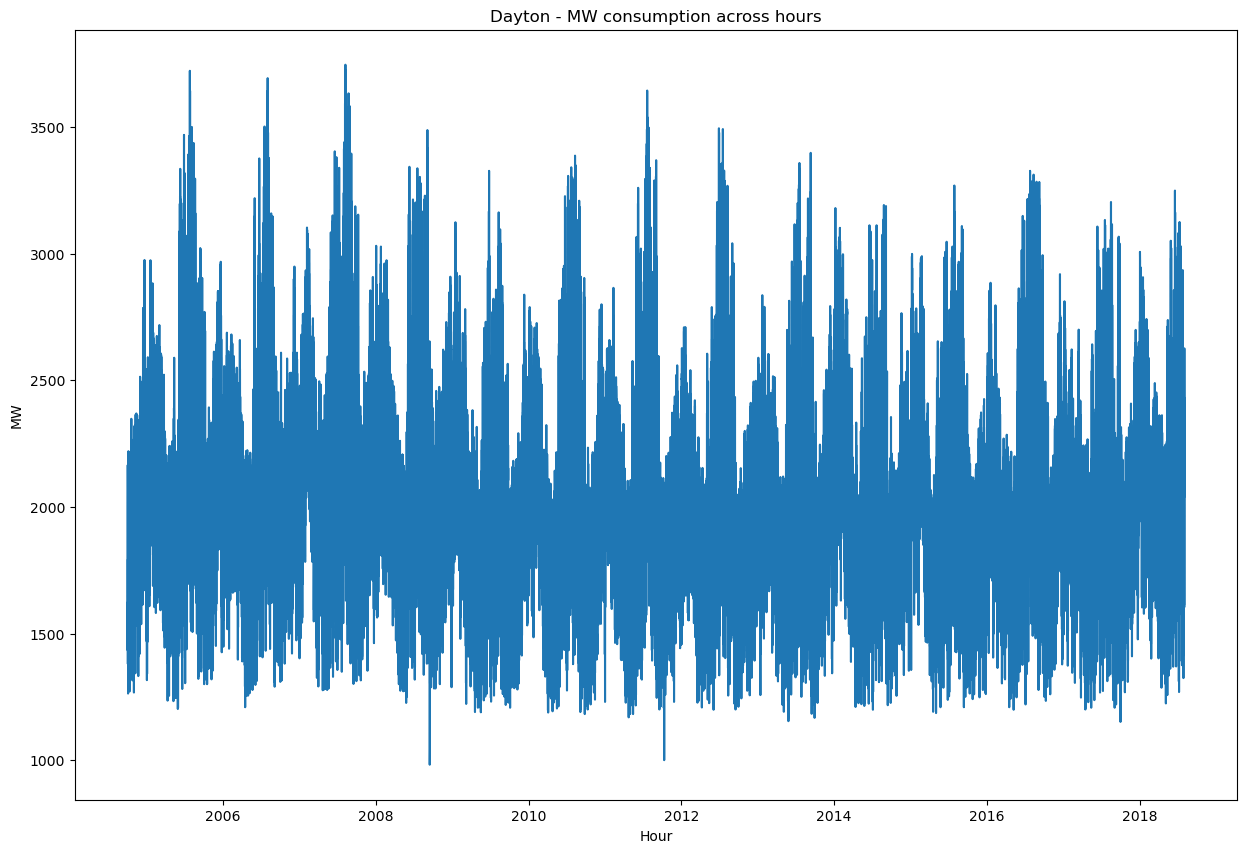

In [10]:
plt.figure(figsize=(15,10))
sns.lineplot(x=data['Datetime'], y=data['DAYTON_MW'])

plt.xlabel("Hour")
plt.ylabel("MW")
plt.title("Dayton - MW consumption across hours")

plt.show()

In [11]:
# Train test split 
def create_data_for_NN(
    data: pd.DataFrame, Y_var: str, lag: int, test_ratio: float
) -> Tuple[np.array, np.array, np.array, np.array]:
    """Function to return lagged time series data after train-test split

    Args:
        data (pd.DataFrame): Raw time series data frame
        Y_var (str): String with the name of y variable
        lag (int): number of lagged records to consider
        test_ratio (float): ratio of data to consider for test set

    Returns:
        Tuple[np.array, np.array, np.array, np.array]: Lagged and split numpy arrays
    """
    y = data[Y_var].tolist()

    X, Y = [], []

    if len(y) - lag <= 0:
        X.append(y)
    else:
        for i in range(len(y) - lag):
            Y.append(y[i + lag])
            X.append(y[i : (i + lag)])

    X, Y = np.array(X), np.array(Y)

    # Reshaping the X array to an LSTM input shape
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))

    # Creating training and test sets
    X_train = X
    X_test = []

    Y_train = Y
    Y_test = []

    if test_ratio > 0:
        index = round(len(X) * test_ratio)
        X_train = X[: (len(X) - index)]
        X_test = X[-index:]

        Y_train = Y[: (len(X) - index)]
        Y_test = Y[-index:]

    return X_train, X_test, Y_train, Y_test


lag = 3
test_ratio = 0.15

X_train, X_test, Y_train, Y_test = create_data_for_NN(
    data, data.columns[-1], lag, test_ratio
)

In [12]:
X_train[0:4]

array([[[1621.],
        [1536.],
        [1500.]],

       [[1536.],
        [1500.],
        [1434.]],

       [[1500.],
        [1434.],
        [1489.]],

       [[1434.],
        [1489.],
        [1620.]]])

In [13]:
Y_train[0:5]

array([1434., 1489., 1620., 1859., 2007.])

----
#### Fit a single layer LSTM with lag = 3 hours

In [14]:

lag = 3
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(data, data.columns[-1], lag, test_ratio)

model_lstm_3 = Sequential([
    LSTM(units=64, input_shape=(lag, 1)),
    Dense(units=1, activation='linear')
])

# Compile the model
model_lstm_3.compile(loss='mse', optimizer='adam')
model_lstm_3.summary()

2023-05-16 21:22:19.938674: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [15]:
# Fit the model
model_lstm_3.fit(X_train, Y_train, epochs=20, batch_size=2000)

Epoch 1/20
52/52 [==============================] - 2s 11ms/step - loss: 4312064.0000
Epoch 2/20
52/52 [==============================] - 1s 11ms/step - loss: 4307664.0000
Epoch 3/20
52/52 [==============================] - 1s 11ms/step - loss: 4304010.5000
Epoch 4/20
52/52 [==============================] - 1s 11ms/step - loss: 4300376.5000
Epoch 5/20
52/52 [==============================] - 1s 11ms/step - loss: 4296752.5000
Epoch 6/20
52/52 [==============================] - 1s 11ms/step - loss: 4293135.5000
Epoch 7/20
52/52 [==============================] - 1s 14ms/step - loss: 4289524.5000
Epoch 8/20
52/52 [==============================] - 1s 12ms/step - loss: 4285917.5000
Epoch 9/20
52/52 [==============================] - 1s 12ms/step - loss: 4282314.0000
Epoch 10/20
52/52 [==============================] - 1s 14ms/step - loss: 4278713.0000
Epoch 11/20
52/52 [==============================] - 1s 12ms/step - loss: 4275115.5000
Epoch 12/20
52/52 [==============================] -

In [25]:
model_lstm_3_accuracy=model_lstm_3.evaluate(X_test, Y_test)
model_lstm_3_accuracy

569/569 [==============================] - 2s 3ms/step - loss: 4190282.7500


4190282.75

-----
#### Fit a single layer LSTM with lag = 24 hours


In [17]:
lag = 24
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(data, data.columns[-1], lag, test_ratio)

model_lstm_24 = Sequential([
    LSTM(units=64, input_shape=(lag, 1)),
    Dense(units=1, activation='linear')
])

# Compile the model
model_lstm_24.compile(loss='mse', optimizer='adam')
model_lstm_24.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 64)                16896     
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


In [18]:
# Fit the model
model_lstm_24.fit(X_train, Y_train, epochs=20, batch_size=2000)

Epoch 1/20
52/52 [==============================] - 5s 69ms/step - loss: 4312829.0000
Epoch 2/20
52/52 [==============================] - 3s 65ms/step - loss: 4306642.5000
Epoch 3/20
52/52 [==============================] - 4s 69ms/step - loss: 4302432.5000
Epoch 4/20
52/52 [==============================] - 4s 70ms/step - loss: 4298293.0000
Epoch 5/20
52/52 [==============================] - 3s 67ms/step - loss: 4294071.0000
Epoch 6/20
52/52 [==============================] - 3s 66ms/step - loss: 4289625.5000
Epoch 7/20
52/52 [==============================] - 4s 68ms/step - loss: 4285453.5000
Epoch 8/20
52/52 [==============================] - 4s 68ms/step - loss: 4281300.5000
Epoch 9/20
52/52 [==============================] - 4s 68ms/step - loss: 4277161.0000
Epoch 10/20
52/52 [==============================] - 3s 64ms/step - loss: 4273033.5000
Epoch 11/20
52/52 [==============================] - 3s 64ms/step - loss: 4268914.5000
Epoch 12/20
52/52 [==============================] -

In [24]:
model_lstm_24_accuracy=model_lstm_24.evaluate(X_test, Y_test)
model_lstm_24_accuracy

569/569 [==============================] - 2s 3ms/step - loss: 4179524.0000


4179524.0

-------
#### Fit a bidirectional LSTM with lag = 24 hours


In [20]:
from keras.layers import Bidirectional

lag = 24
test_ratio = 0.15
X_train, X_test, Y_train, Y_test = create_data_for_NN(data, data.columns[-1], lag, test_ratio)

model_lstm_24_bi = Sequential([
    Bidirectional(LSTM(units=64, input_shape=(lag, 1))),
    Dense(units=1, activation='linear')
])

# Compile the model
model_lstm_24_bi.compile(loss='mse', optimizer='adam')

In [21]:
# Fit the model
model_lstm_24_bi.fit(X_train, Y_train, epochs=20, batch_size=2000)

Epoch 1/20
52/52 [==============================] - 7s 100ms/step - loss: 4305499.5000
Epoch 2/20
52/52 [==============================] - 5s 102ms/step - loss: 4298818.5000
Epoch 3/20
52/52 [==============================] - 5s 96ms/step - loss: 4292702.0000
Epoch 4/20
52/52 [==============================] - 5s 99ms/step - loss: 4286618.5000
Epoch 5/20
52/52 [==============================] - 5s 100ms/step - loss: 4280315.0000
Epoch 6/20
52/52 [==============================] - 5s 97ms/step - loss: 4273576.5000
Epoch 7/20
52/52 [==============================] - 5s 95ms/step - loss: 4267120.0000
Epoch 8/20
52/52 [==============================] - 5s 93ms/step - loss: 4260749.5000
Epoch 9/20
52/52 [==============================] - 5s 99ms/step - loss: 4254424.0000
Epoch 10/20
52/52 [==============================] - 5s 92ms/step - loss: 4248089.5000
Epoch 11/20
52/52 [==============================] - 5s 92ms/step - loss: 4240762.0000
Epoch 12/20
52/52 [==============================

In [22]:
model_lstm_24_bi_accuracy=model_lstm_24_bi.evaluate(X_test, Y_test)
model_lstm_24_bi_accuracy

569/569 [==============================] - 2s 3ms/step - loss: 4128097.0000


4128097.0

----
#### Plot results on test set and compare performance using RMSE


In [29]:
models=['LSTM_LAG_3','LSTM_LAG_24','LSTM_LAG_24BI']
accuracy=[np.sqrt(model_lstm_3_accuracy), np.sqrt(model_lstm_24_accuracy), np.sqrt(model_lstm_24_bi_accuracy)]

mod_test_accuracy=pd.DataFrame({'RNN_Models':models,'Test_Accuracy':accuracy})
mod_test_accuracy

,RNN_Models,Test_Accuracy
0,LSTM_LAG_3,2047.018014
1,LSTM_LAG_24,2044.388417
2,LSTM_LAG_24BI,2031.771887


Text(0.5, 1.0, 'Test RMSE for different RNN Models')

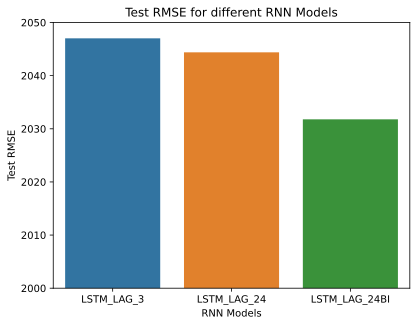

In [35]:
sns.barplot(x=models, y=accuracy)

# Set plot labels and title
plt.xlabel('RNN Models')
plt.ylabel('Test RMSE')
plt.ylim(2000, 2050)
plt.title('Test RMSE for different RNN Models')

As we can see, all 3 models perform similarly on RMSE. Bidirectional LSTM with a lag of 24 yields the best results for this data 

-------
End of assignment